In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import pickle

import tensorflow as tf

2023-06-08 09:55:43.874755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 09:55:46.710493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-08 09:55:46.710605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d
from custom_plots import plot_sbc_ecdf

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from tensorflow_probability import distributions as tfd

In [4]:
plt.rcParams.update({
    "axes.labelsize" : 24,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize": 24,
    "text.usetex": False,
    "font.family": "serif",
    #"font.serif": ["times"],
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

# Benchmark: SIR

In [5]:
benchmark_name = 'sir'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the sir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [36]:
# Mock summary net 
summary_net = lambda x, **kwargs: x[:, :, 0]


# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*2, scale=tf.linalg.LinearOperatorDiag([1.]*2))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*10, scale=tf.linalg.LinearOperatorDiag([1.]*10))

likelihood_settings = {
    'dense_args': dict(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    'num_dense': 1,
    'dropout_prob': 0.05
}

posterior_settings = {
    'dense_args': dict(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    'num_dense': 1,
    'dropout_prob': 0.05
}

amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        InvertibleNetwork(num_params=2, coupling_settings=posterior_settings, num_coupling_layers=6,coupling_design='spline'),
        summary_net=summary_net,
        latent_dist=latent_dist_p
    ),
    AmortizedLikelihood(
        InvertibleNetwork(num_params=10, coupling_settings=likelihood_settings, num_coupling_layers=8),
        latent_dist=latent_dist_l
    )
)

In [37]:
def custom_configure(forward_dict, preconfigured=False):
    """Custom configurator to increase stability due to poor likelihood simulator."""
    
    if not preconfigured:
        output_dict = benchmark.configurator(forward_dict, as_summary_condition=True)
    else:
        output_dict = forward_dict
    obs_shape = output_dict['likelihood_inputs']['observables'].shape
    cond_shape = output_dict['posterior_inputs']['summary_conditions'].shape
    # Stability
    output_dict['likelihood_inputs']['observables'] += 1e-3 * np.random.normal(size=obs_shape)
    output_dict['posterior_inputs']['summary_conditions'] += 1e-3 * np.random.normal(size=cond_shape)
    return output_dict

In [38]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=custom_configure,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall-clock time on GPU: 1h 32min 48s

In [43]:
# EPOCHS = 250
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 32

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [42]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

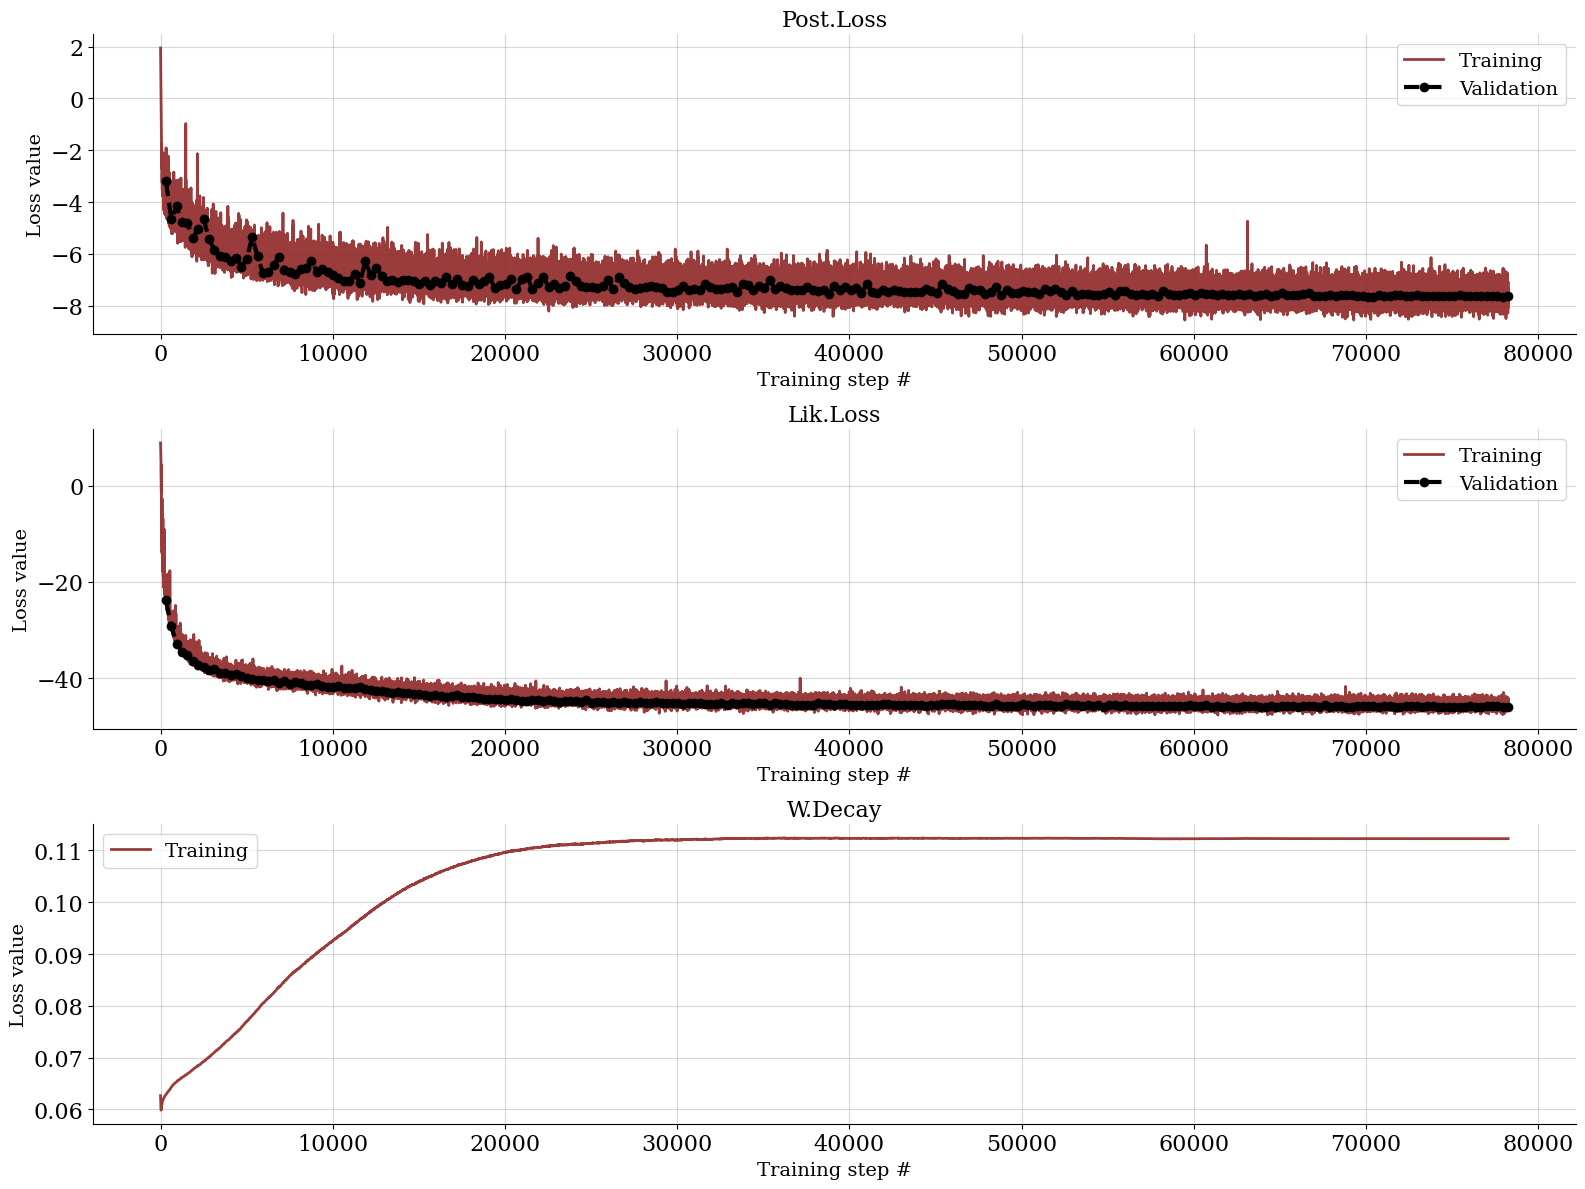

In [44]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [45]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [46]:
test_dict = custom_configure(test_dict, preconfigured=True)

In [47]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'summary_conditions': x_sim_s[:, :, np.newaxis]}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

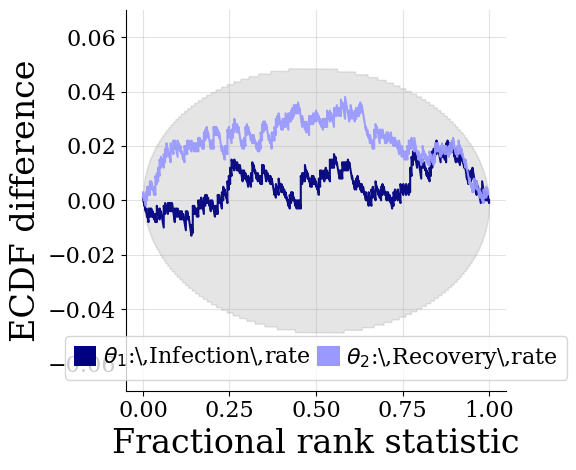

In [48]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    label_fontsize=24, legend_fontsize=16,       
    difference=True, 
    param_names=[r'$\theta_1$:\,Infection\,rate', r'$\theta_2$:\,Recovery\,rate'], 
    rank_ecdf_colors=['#000080', '#9999FF'],
    legend_spacing = 0.3, 
    ylim = (-0.07, 0.07)
)

f.savefig(f'figures/{benchmark_name}_diff_ind_post.pdf', dpi=300, bbox_inches='tight')

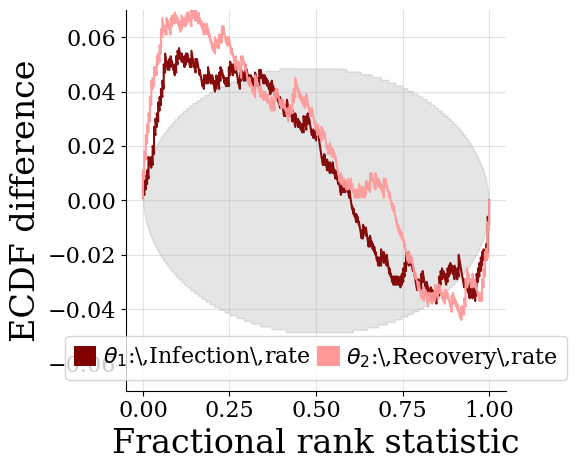

In [49]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    label_fontsize=24, 
    legend_fontsize=16,
    difference=True, 
    param_names=[r'$\theta_1$:\,Infection\,rate', r'$\theta_2$:\,Recovery\,rate'], 
    rank_ecdf_colors=['#800000', '#FF9999'],
    legend_spacing = 0.3, 
    ylim=(-0.07, 0.07)
)

f.savefig(f'figures/{benchmark_name}_diff_ind_joint.pdf', dpi=300, bbox_inches='tight')

## Recovery

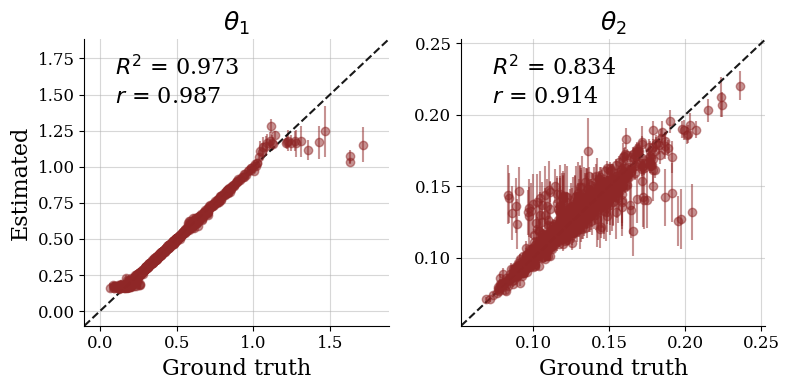

In [50]:
f = plot_recovery(post_samples, prior_samples)

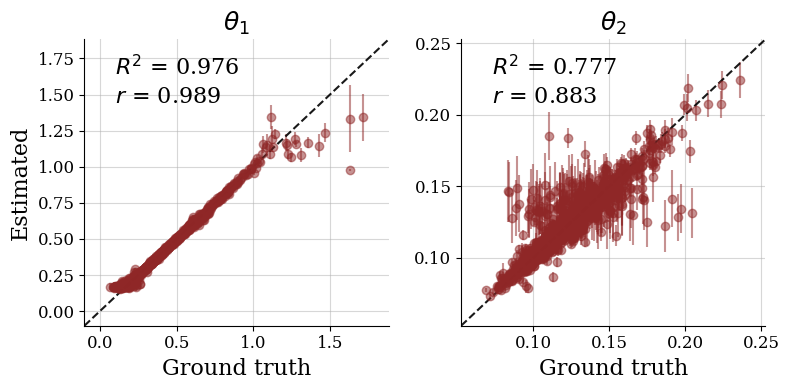

In [51]:
f = plot_recovery(post_samples_s, prior_samples)

# Appendix Plots

In [52]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

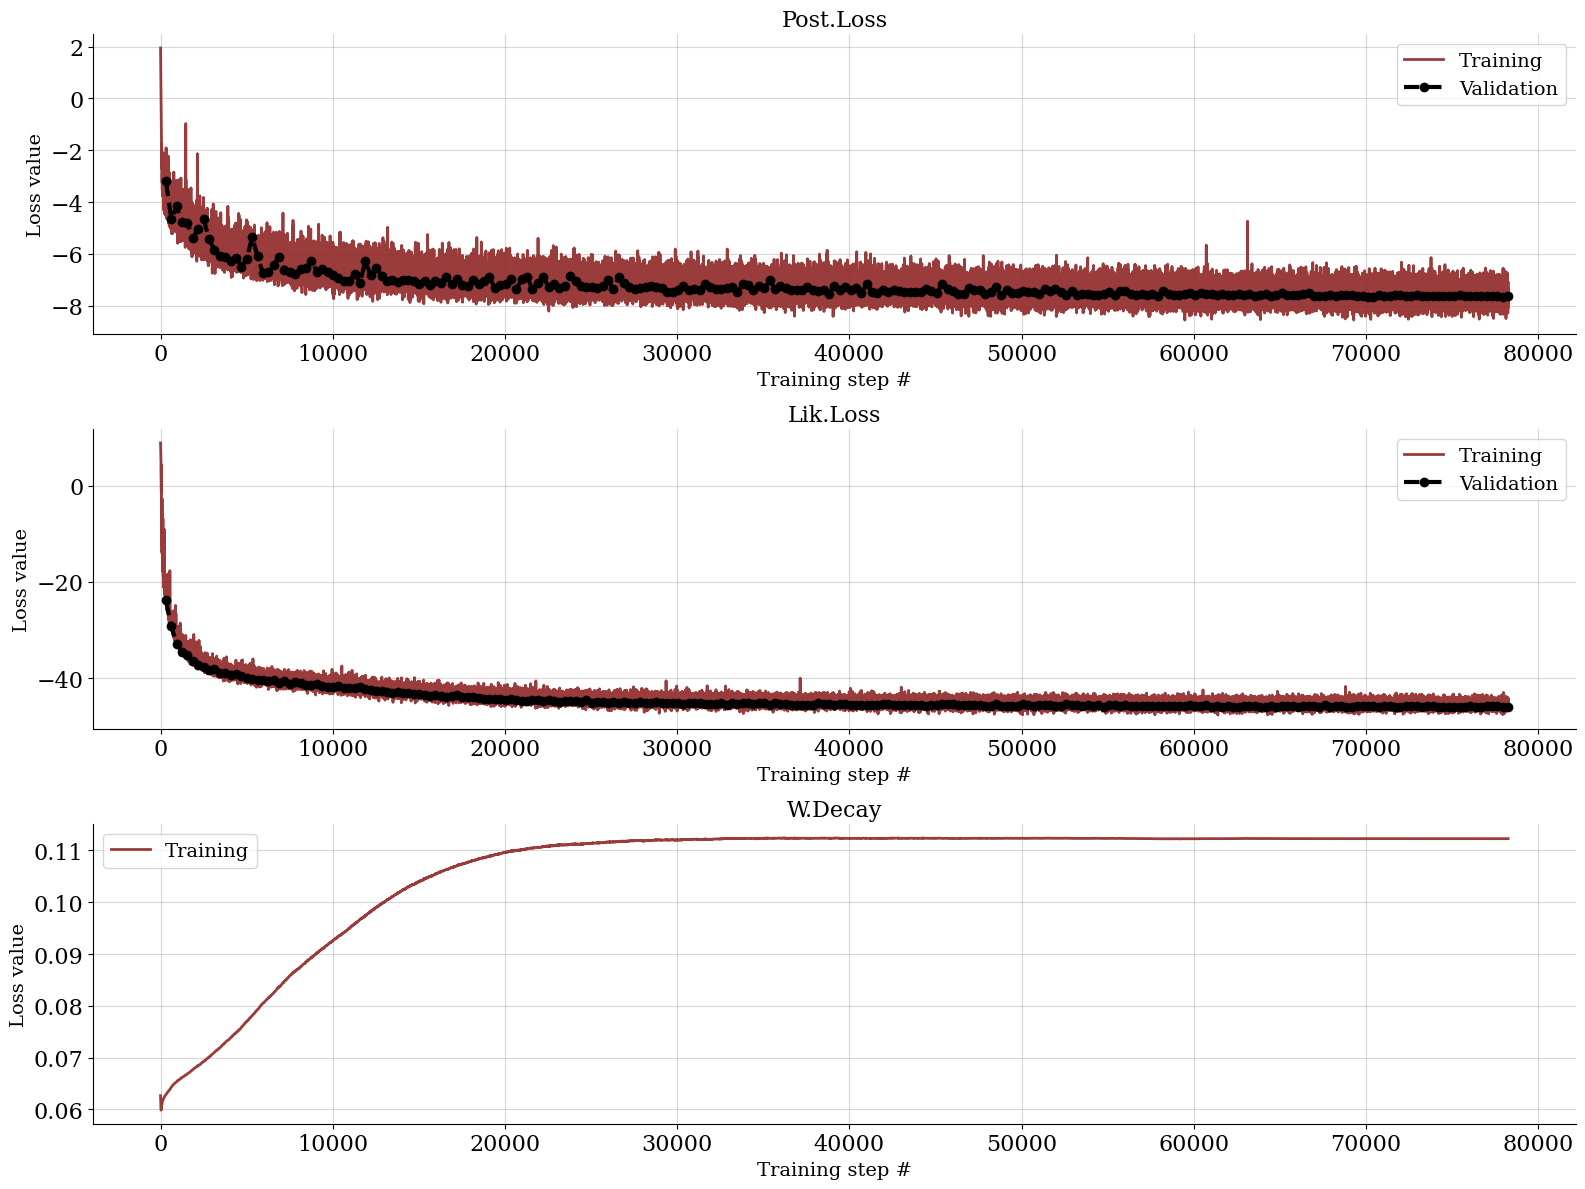

In [53]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

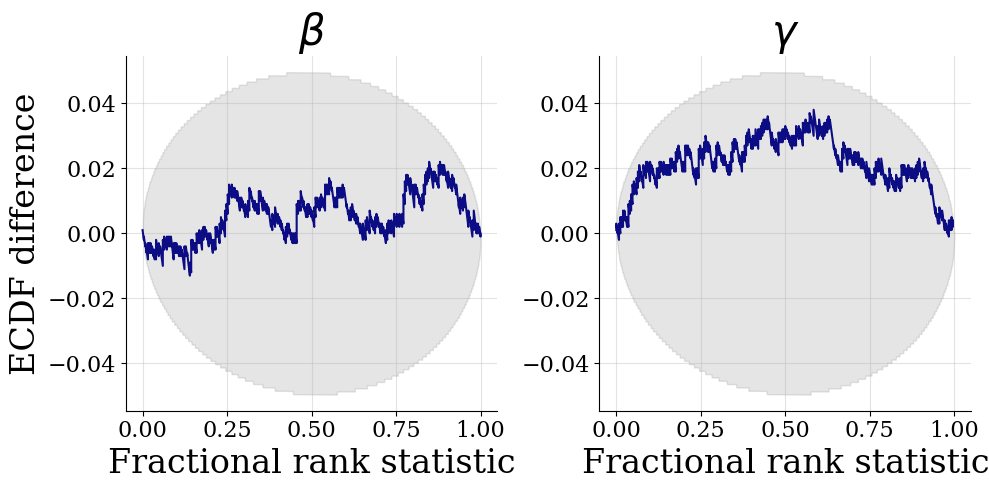

In [54]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

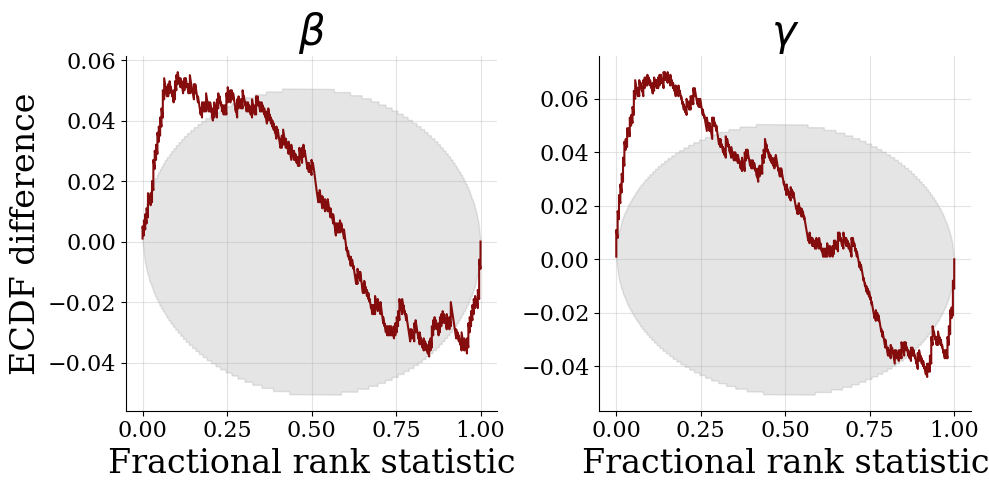

In [55]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")